# Machine Learning Project

In [1]:
# Mount GDrive, change directory and check contents of folder.

import os
from google.colab import drive
from google.colab import files

PROJECT_FOLDER = "/content/gdrive/My Drive/Colab Notebooks/CS345_SP22/6. CNN"

drive.mount('/content/gdrive/')
os.chdir(PROJECT_FOLDER)
print("Current dir: ", os.getcwd())

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Current dir:  /content/gdrive/My Drive/Colab Notebooks/CS345_SP22/6. CNN


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from mllib.utils import RandomSeed

# __________ | Settings | __________
IS_PLOTING_DATA         = True
IS_DEBUGABLE            = False
IS_RETRAINING           = True
RandomSeed(2022)

Random seed set to 2022


# Hyperparameters
For each training experiment, we define all the model/training hyperparameters inside a Python dictionary.


**Deep Learning Techniques**:

* L2 Regularization with a given weight decay will try to keep small weights preventing overfitting. It can be applied to specific layers.
* Momentum can be using during training to include the error from the previous epoch.
* Learning Rate scheduling, a list that contains paris of [epoch,lr]. We set learning rate at a specific value at a given epoch


In [3]:
CONFIG_CUSTOM_CNN = {
                 "ModelName": "CIFAR10_MyCustomCNN"
                ,"CNN.InputShape": [32,32,3]
                ,"CNN.Classes": 10
                ,"CNN.ConvOutputFeatures": [32,32,64,128,256]
                ,"Training.MaxEpoch": 50
                ,"Training.BatchSize": 128
                ,"Training.LearningRate": 0.05
                ,"Training.LearningRateScheduling": [[20,0.01], [40,0.005]]
                ,"Training.Momentum": 0.9
                ,"Training.RegularizeL2": True
                ,"Training.WeightDecay": 1e-4
            }
                
CONFIG = CONFIG_CUSTOM_CNN
                     

We choose the hyperparameter set for the current model training experiment

In [4]:
CONFIG = CONFIG_CUSTOM_CNN

# CIFAR10
The [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, that dates back to 2009, has become a standard toy dataset to understand the image classification task. It contains 60000 tiny color images of 32x32 resolution for the classes
1. airplane, 2. automobile, 3. bird, 4. cat , 5. deer, 6. dog, 7. frog, 8. horse, 9. ship, 10. truck
                               
It is already splitted into a training set of 50000 images (5000 images per class), while the rest 10000 (1000 images per classe) are used to validate the model

# Dataset loading
We are using a custom implementation of the dataset that downloads and converts the images into Python pickle files. 

In [5]:
from datasets.cifar10.dataset import CCIFAR10DataSet

# ... // Create the data objects \\ ...
oDataset = CCIFAR10DataSet()
print("Training samples set shape:", oDataset.TSSamples.shape)
print("Validation samples set shape:", oDataset.VSSamples.shape)

mean = np.mean(oDataset.TSSamples, axis=(0,1,2))
std = np.std(oDataset.TSSamples, axis=(0,1,2))

# Standardize the datasets with the mean and st dev of the trainig samples
oDataset.TSSamples = (oDataset.TSSamples - mean) / std
oDataset.VSSamples = (oDataset.VSSamples - mean) / std
print(mean)
print(std)

Training samples set shape: (50000, 32, 32, 3)
Validation samples set shape: (10000, 32, 32, 3)
[83.88608 83.88608 83.88608]
[70.49192 68.40918 68.15831]


# Data Feeding for Training and Validation
We create two data feeding objects that speed-up the loading of samples to the model's input. We use the `tf.data.Dataset` class and its method `from_tensor_slices()` to create the data feed object supplying as parameters the numpy arrays for the features of all TS samples `oDataset.TSSamples` and the corresponding class labels `oDataset.TSLabels`. We do the same for the VS.


In [6]:
# -----------------------------------------------------------------------------
def __normalizeImage(p_tImage):
    # Normalizes color component values from `uint8` to `float32`.
    # return tf.cast(p_tImage, tf.float32) / 255.
    return p_tImage
# ------------------------------------------------------------------------------
def PreprocessImageAugmentDataset(p_tImageInTS, p_tLabelInTS):
    # Normalizes color component values from `uint8` to `float32`.
    tNormalizedImage = __normalizeImage(p_tImageInTS)
    # Calls the data augmentation function that add new random samples, i.e.augments the dataset. 
    

    # Resizes the image to 40x40 by padding with zeroes.
    # tNewRandomImage = tf.image.pad_to_bounding_box(tNormalizedImage, 4, 4, 40, 40)

    # # Randomly crops the image back to 32x32.
    # tNewRandomImage = tf.image.random_crop(tNewRandomImage, [32, 32, 3])

    # Flips the image randomly
    tNewRandomImage = tf.image.random_flip_left_right(tNormalizedImage)
    
    # Target class labels into one-hot encoding
    tTargetOneHot = tf.one_hot(p_tLabelInTS, CONFIG["CNN.Classes"])
    
    return tNewRandomImage, tTargetOneHot
# -----------------------------------------------------------------------------------
nBatchSize = CONFIG["Training.BatchSize"]

# Training data feed pipeline
oTSData = tf.data.Dataset.from_tensor_slices((oDataset.TSSamples, oDataset.TSLabels))
oTSData = oTSData.map(PreprocessImageAugmentDataset, num_parallel_calls=tf.data.AUTOTUNE)
oTSData = oTSData.cache()
oTSData = oTSData.shuffle(oDataset.TSSampleCount)
oTSData = oTSData.batch(nBatchSize)
print("Will shuffle all the %d samples in the TS before splitting into batches with %d samples/batch" % (oDataset.TSSampleCount, nBatchSize))




# Validation data feed pipeline
# -----------------------------------------------------------------------------------
def PreprocessImage(p_tImageInVS, p_tLabelInVS):
    # Normalizes color component values from `uint8` to `float32`.
    tNormalizedImage = __normalizeImage(p_tImageInVS)
    # Target class labels into one-hot encoding
    tTargetOneHot = tf.one_hot(p_tLabelInVS, CONFIG["CNN.Classes"])
    
    return tNormalizedImage, tTargetOneHot
# -----------------------------------------------------------------------------------
oVSData = tf.data.Dataset.from_tensor_slices((oDataset.VSSamples, oDataset.VSLabels))
oVSData = oVSData.map(PreprocessImage, num_parallel_calls=tf.data.AUTOTUNE)
oVSData = oVSData.batch(oDataset.VSSampleCount)
print("One batch for all the %d samples in the VS" % oDataset.VSSampleCount)

print("."*50)
print("Training data feed object:", oTSData)
print("Validation data feed object:", oVSData)

Will shuffle all the 50000 samples in the TS before splitting into batches with 128 samples/batch
One batch for all the 10000 samples in the VS
..................................................
Training data feed object: <BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
Validation data feed object: <BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


For training there is a pre-processing pipeline:
* We normalize each sample in the scale [0,1]
* We do a random left-right flip to create a new random sample, out of the original one.
* We cache the TS (for speed)
* We shuffle the TS.
* We split the TS into minibatches, that will be fed input the model's input in each training steps of the epoch. 

For validation we must not do the random augmentation, no shuffling is needed but must do the same normalization.


**Deep Learning techniques**: The training pipeline implements 

* Input feature normalization.
* Dataset augmentation.
* Random minibatch sampling out of the available TS samples.


# Custom Complex CNN Architecture
We will declare a `keras.Model` descendant class to implement our complex CNN. We will create convolutional modules, from `keras.Layer` descendants that can contain multiple keras layers, which complex connections.

**Deep Learning Techniques**:

* We choose a proper weight initialization method, here `glorot_uniform`. You can try with `he_normal`.
* The convolutional kernels inside the modules are regularized.
* We are using the **DropOut** technique. We will randomly keep only a fraction of the input neurons (e.g. 60%) for the logits inside a training step. The rest 40% of the neurons are not trained. In the next step a different 60% of the neurons are trained.This mitigates overfitting because we have fewer neurons to train.

In [7]:
# __________ // Create the Machine Learning model and training algorithm objects \\ __________
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from models.ConvModules import CBasicConvModule
from models.ConvModules import CInceptionModule
from mllib.helpers import CKerasModelStructure, CModelConfig

# =========================================================================================================================
class CMyCustomCNN(keras.Model):
    # --------------------------------------------------------------------------------------
    # Constructor
    def __init__(self, p_oConfig):
      super(CMyCustomCNN, self).__init__()
      
      # ..................... Object Attributes ...........................
      self.Config = CModelConfig(self, p_oConfig)
      
      self.ClassCount         = self.Config.Value["CNN.Classes"]
      self.ConvLayerFeatures  = self.Config.Value["CNN.ConvOutputFeatures"]
      self.Structure = None 
      # ......... Keras layers .........
      self.StemConv1              = None
      self.StemActivation1        = None
      self.StemBatchNorm1         = None
      
      self.StemConv2              = None
      self.StemActivation2        = None
      self.StemBatchNorm2         = None
      
      self.Module1                = None
      self.Module2                = None
      self.Module3                = None
      
      self.GlobalAveragePooling   = None
      self.DropOut                = None
      self.Logits                 = None
      self.SoftmaxActivation      = None
      # ...................................................................
      
      
      self.Create()
    # --------------------------------------------------------------------------------------------------------
    def createWeightRegulizer(self):
        if self.Config.Value["Training.RegularizeL2"]:
            oWeightRegularizer = regularizers.L2(self.Config.Value["Training.WeightDecay"])
        else:
            oWeightRegularizer = None
        return oWeightRegularizer          
    # --------------------------------------------------------------------------------------
    def Create(self): 
        self.StemConv1        = layers.Conv2D(self.ConvLayerFeatures[0], kernel_size=(3,3), strides=1, padding="same"
                                          , use_bias=False
                                          , kernel_initializer="glorot_uniform"
                                          , bias_initializer="zeros"
                                          , kernel_regularizer=self.createWeightRegulizer()
                                          )
        self.StemActivation1 = layers.Activation("relu")
        self.StemBatchNorm1  = layers.BatchNormalization()
        
        
        self.StemConv2        = layers.Conv2D(self.ConvLayerFeatures[1], kernel_size=(3,3), strides=2, padding="same"
                                          , use_bias=False
                                          , kernel_initializer="glorot_uniform"
                                          , bias_initializer="zeros"  
                                          , kernel_regularizer=self.createWeightRegulizer()
                                          )     
        self.StemActivation2        = layers.Activation("relu")
        self.StemBatchNorm2         = layers.BatchNormalization()
        

                
        # ..... PLACE YOUR CUSTOM ARCHITECTURE HERE .....
        oCommonModuleConfig={  "Convolution.Features"           : None 
                              ,"Convolution.PaddingSize"        : 1
                              ,"Convolution.WindowSize"         : 3
                              ,"Convolution.Stride"             : 1
                              ,"Convolution.KernelInitializer"  : "glorot_uniform"
                              ,"Convolution.HasBias"            : False
                              ,"Convolution.BiasInitializer"    : None
                              ,"Convolution.RegularizeL2"       : self.Config.Value["Training.RegularizeL2"]
                              ,"Convolution.WeightDecay"        : self.Config.Value["Training.WeightDecay"]
                              ,"ActivationFunction"             : "relu"
                              ,"Normalization"                  : "BatchNormalization"
                            }
      
        # ... = CBasicConvModule(self, oCommonModuleConfig, self.ConvLayerFeatures[3],p_bIsMaxPoolDownsampling=True)

        self.Module1 = CInceptionModule(self, oCommonModuleConfig, self.ConvLayerFeatures[0])
        self.DropoutConv = layers.Dropout(rate = 0.4)                         #Make rate a self.Config.Value["CNN.DropoutProbability"]
        self.Module2 = CInceptionModule(self, oCommonModuleConfig, self.ConvLayerFeatures[1])
        self.Module3 = CInceptionModule(self, oCommonModuleConfig, self.ConvLayerFeatures[2],p_bIsMaxPoolDownsampling=True)
        self.Module4 = CInceptionModule(self, oCommonModuleConfig, self.ConvLayerFeatures[3],p_bIsMaxPoolDownsampling=True)
        self.Module5 = CInceptionModule(self, oCommonModuleConfig, self.ConvLayerFeatures[4])

      
        # Using Global Average Pooling to flatten the activation tensor into an average vector
        self.GlobalAveragePooling = layers.GlobalAveragePooling2D()
        
        # Using dropout to keep 60% of the neurons randomly in each step of the training process. This mitigates overfitting. 
        self.DropOut = layers.Dropout(rate=0.4)

        # Output layer with class neurons that will use the SoftMax activation function    
        self.Logits = layers.Dense(self.ClassCount
                                         , use_bias=True
                                         , kernel_initializer="glorot_uniform"
                                         , bias_initializer="zeros"
                                         , kernel_regularizer=self.createWeightRegulizer()
                                   )
        self.SoftmaxActivation = layers.Softmax()           
    # --------------------------------------------------------------------------------------------------------
    def call(self, p_tInput):
        # Lazy initialization of the model structure. Will run the logic of adding keras layer to the structure just once.
        bPrint = self.Structure is None
        if bPrint:
            self.Structure = CKerasModelStructure()
            
        # ....... Stem  .......
        tA = p_tInput
        if bPrint:
            self.Structure.Add(tA)
        
        # First learnable convolutional module
        tA = self.StemConv1(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        tA = self.StemActivation1(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        tA = self.StemBatchNorm1(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        # Second learnable convolutional module
        tA = self.StemConv2(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        tA = self.StemActivation2(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        tA = self.StemBatchNorm2(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        
        
        # ....... Core  .......
        # ..... PLACE YOUR CUSTOM ARCHITECTURE HERE .....
        tA = self.Module1(tA)
        if bPrint:
            self.Structure.Add(tA)

        tA = self.Module2(tA)
        if bPrint:
            self.Structure.Add(tA)
            
        tA = self.DropoutConv(tA)
        if bPrint:
            self.Structure.Add(tA)
            
        tA = self.Module3(tA)
        if bPrint:
            self.Structure.Add(tA)

        tA = self.DropoutConv(tA)
        if bPrint:
            self.Structure.Add(tA)

        tA = self.Module4(tA)
        if bPrint:
            self.Structure.Add(tA)  

        tA = self.Module5(tA)
        if bPrint:
            self.Structure.Add(tA)

        # ....... Classifier  .......
        tA = self.GlobalAveragePooling(tA)
        if bPrint:
            self.Structure.Add(tA)

        tA = self.DropOut(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        tA = self.Logits(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        tA = self.SoftmaxActivation(tA)
        if bPrint:
            self.Structure.Add(tA)
        
        return tA
    # --------------------------------------------------------------------------------------------------------
# =========================================================================================================================

# Create the Neural Network model and training algorithm objects
**Deep Learning techniques**

*   Learning rate scheduling, for more fine-grained weight updates after some epoch
*   Momentum, to improve convergence and avoid local error minima.



In [8]:
oNN = CMyCustomCNN(CONFIG)

# -----------------------------------------------------------------------------------
def LRSchedule(epoch, lr):
    nNewLR = lr
    for nIndex,oSchedule in enumerate(CONFIG["Training.LearningRateScheduling"]):
        if epoch == oSchedule[0]:
            nNewLR = oSchedule[1]
            print("Schedule #%d: Setting LR to %.5f" % (nIndex+1,nNewLR))
            break
    return nNewLR
# -----------------------------------------------------------------------------------    

nInitialLearningRate    = CONFIG["Training.LearningRate"]  
  

oCostFunction   = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
oOptimizer = tf.keras.optimizers.SGD(learning_rate=nInitialLearningRate, momentum=CONFIG["Training.Momentum"])
if CONFIG["Training.LearningRateScheduling"] is not None:
  oCallbacks = [tf.keras.callbacks.LearningRateScheduler(LRSchedule)]
else:
  oCallbacks = None

#### Inspect the model architecture

In [9]:
# Compile the model for training
sModelFolderName = CONFIG["ModelName"]
        
bIsCompiledForTraining = False
if not os.path.isdir(sModelFolderName) or IS_RETRAINING:
    oNN.compile(loss=oCostFunction, optimizer=oOptimizer, metrics=["accuracy"])
    oNN.predict(oVSData)
    oNN.Structure.Print("Model-Structure-%s.csv" % CONFIG["ModelName"])
    bIsCompiledForTraining = True

    oNN.summary()
    

0                                                IteratorGetNext:0 (None, 32, 32, 3)
1                                  c_my_custom_cnn/conv2d/Conv2D:0 (None, 32, 32, 32)
2                                c_my_custom_cnn/activation/Relu:0 (None, 32, 32, 32)
3           c_my_custom_cnn/batch_normalization/FusedBatchNormV3:0 (None, 32, 32, 32)
4                                c_my_custom_cnn/conv2d_1/Conv2D:0 (None, 16, 16, 32)
5                              c_my_custom_cnn/activation_1/Relu:0 (None, 16, 16, 32)
6         c_my_custom_cnn/batch_normalization_1/FusedBatchNormV3:0 (None, 16, 16, 32)
7 c_my_custom_cnn/c_inception_module/batch_normalization_2/FusedBatchNormV3:0 (None, 18, 18, 96)
8 c_my_custom_cnn/c_inception_module_1/batch_normalization_3/FusedBatchNormV3:0 (None, 20, 20, 96)
9                               c_my_custom_cnn/dropout/Identity:0 (None, 20, 20, 96)
10   c_my_custom_cnn/c_inception_module_2/max_pooling2d_3/MaxPool:0 (None, 11, 11, 192)
11                           

### Train and evalute the model

In [10]:
if bIsCompiledForTraining:
    # Train the model
    if IS_DEBUGABLE:
        oNN.run_eagerly = True
        
    oProcessLog = oNN.fit(  oTSData, batch_size=nBatchSize
                            ,epochs=CONFIG["Training.MaxEpoch"]
                            ,validation_data=oVSData
                            ,callbacks=oCallbacks
                          )
    # oNN.summary()          
    oNN.save(sModelFolderName)      
else:
    # The model is trained and its state is saved (all the trainable parameters are saved). We load the model to recall the samples 
    oNN = keras.models.load_model(sModelFolderName)
    oProcessLog = None
    # oNN.summary()    


Epoch 1/50
391/391 [==============================] - 36s 80ms/step - loss: 1.6631 - accuracy: 0.4743 - val_loss: 1.4949 - val_accuracy: 0.5515 - lr: 0.0500
Epoch 2/50
391/391 [==============================] - 30s 77ms/step - loss: 1.2791 - accuracy: 0.6267 - val_loss: 1.3310 - val_accuracy: 0.6180 - lr: 0.0500
Epoch 3/50
391/391 [==============================] - 30s 76ms/step - loss: 1.1134 - accuracy: 0.6891 - val_loss: 1.1343 - val_accuracy: 0.6847 - lr: 0.0500
Epoch 4/50
391/391 [==============================] - 30s 77ms/step - loss: 1.0015 - accuracy: 0.7288 - val_loss: 1.1448 - val_accuracy: 0.6818 - lr: 0.0500
Epoch 5/50
391/391 [==============================] - 30s 77ms/step - loss: 0.9270 - accuracy: 0.7563 - val_loss: 1.0868 - val_accuracy: 0.7176 - lr: 0.0500
Epoch 6/50
391/391 [==============================] - 30s 77ms/step - loss: 0.8644 - accuracy: 0.7781 - val_loss: 1.0709 - val_accuracy: 0.7208 - lr: 0.0500
Epoch 7/50
391/391 [==============================] - 30s 

INFO:tensorflow:Assets written to: CIFAR10_MyCustomCNN/assets


INFO:tensorflow:Assets written to: CIFAR10_MyCustomCNN/assets


# Learning Process Overview

Keys of Keras training process log: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


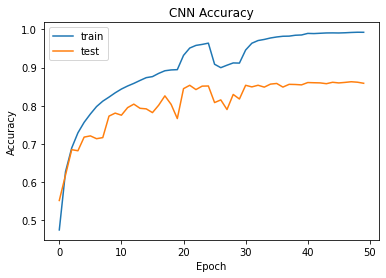

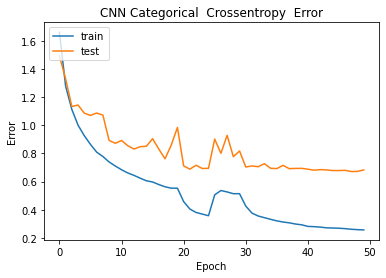

In [11]:
if oProcessLog is not None: # [PYTHON] Checks that object reference is not Null
    # list all data in history
    print("Keys of Keras training process log:", oProcessLog.history.keys())
    
    # Plot the accuracy during the training epochs
    plt.plot(oProcessLog.history['accuracy'])
    plt.plot(oProcessLog.history['val_accuracy'])
    plt.title('CNN Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Plot the error during the training epochs
    sCostFunctionNameParts = oCostFunction.name.split("_")                           # [PYTHON]: Splitting string into an array of strings
    sCostFunctionNameParts = [x.capitalize() + " " for x in sCostFunctionNameParts]  # [PYTHON]: List comprehension example 
    sCostFunctionName = " ".join(sCostFunctionNameParts)                             # [PYTHON]: Joining string in a list with the space between them
    
    
    plt.plot(oProcessLog.history['loss'])
    plt.plot(oProcessLog.history['val_loss'])
    plt.title('CNN ' + sCostFunctionName + " Error")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Inference / Evaluation

                    Predicted  
               ----------------------------------------------------
        Actual |  855    1   45   10   23    4    5    4   46    7 |
               |   14  897    3    9    3    2   12    1   18   41 |
               |   24    0  793   38   60   30   49    3    2    1 |
               |    5    1   33  750   60   96   42    5    4    4 |
               |    3    0   15   26  920   10   19    5    2    0 |
               |    3    0   17  144   43  769   16    8    0    0 |
               |    5    0   14   34   20    5  920    1    1    0 |
               |    5    0   17   32   58   37    1  849    1    0 |
               |   25    3   10   13    3    2    4    0  936    4 |
               |   15   33    6   10    2    4    5    4   23  898 |
               ----------------------------------------------------
Per Class Recall (Accuracy)  : [0.855 0.897 0.793 0.75  0.92  0.769 0.92  0.849 0.936 0.898]
Per Class Precision          : [0.89622642 0.9593

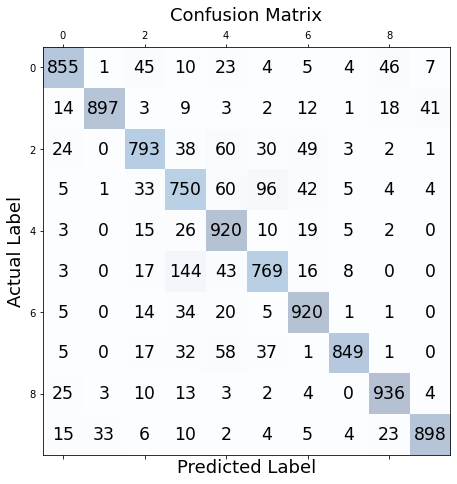

In [12]:
from mllib.evaluation import CEvaluator
from mllib.visualization import CPlotConfusionMatrix

# Takes one minibatch that is the whole VS.
for tImages, tLabels in oVSData.take(1):
    nImages            = tImages.numpy()
    nTargetClassOneHot = tLabels.numpy()  
nTargetClassLabels = np.argmax(nTargetClassOneHot, axis=1)

nPredictedProbabilities = oNN.predict(nImages)
nPredictedClassLabels  = np.argmax(nPredictedProbabilities, axis=1)

oEvaluator = CEvaluator(nTargetClassLabels, nPredictedClassLabels)

oEvaluator.PrintConfusionMatrix()
print("Per Class Recall (Accuracy)  :", oEvaluator.Recall)
print("Per Class Precision          :", oEvaluator.Precision)
print("Average Accuracy: %.4f" % oEvaluator.AverageRecall)
print("Average F1 Score: %.4f" % oEvaluator.AverageF1Score)
      
oConfusionMatrixPlot = CPlotConfusionMatrix(oEvaluator.ConfusionMatrix)
oConfusionMatrixPlot.Show()      
